In [8]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt

In [9]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [10]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.user_mf_embeded = nn.Embedding(nb_users, mf_dim)
        self.item_mf_embeded = nn.Embedding(nb_items, mf_dim)
        self.user_mlp_embeded = nn.Embedding(nb_users, int(mlp_layer_sizes[0] / 2))
        self.item_mlp_embeded = nn.Embedding(nb_items, int(mlp_layer_sizes[0] / 2))
        self.dropout = dropout
    
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList()
        for i in range(1, nb_mlp_layers):
            self.mlp.extend([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])])  
        self.final = nn.Linear(mlp_layer_sizes[-1] + mf_dim, 1)
        
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot (final MLP has to use lecunn

        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)

        self.user_mf_embeded.weight.data.normal_(0., 0.01)
        self.item_mf_embeded.weight.data.normal_(0., 0.01)
        self.user_mlp_embeded.weight.data.normal_(0., 0.01)
        self.item_mlp_embeded.weight.data.normal_(0., 0.01)
        # glorot_uniform(self.user_mf_embeded)
        # glorot_uniform(self.item_mf_embeded)
        # glorot_uniform(self.user_mlp_embeded)
        # glorot_uniform(self.user_mlp_embeded)

        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        user_mf_embeded = self.user_mf_embeded(user)
        item_mf_embeded = self.item_mf_embeded(item)
        mf = user_mf_embeded * item_mf_embeded

        user_mlp_embeded = self.user_mlp_embeded(user)
        item_mf_embeded = self.item_mlp_embeded(item)
        mlp = torch.cat((user_mlp_embeded, item_mf_embeded), dim=1)
        for i, layer in enumerate(self.mlp):
            mlp = layer(mlp)
            mlp = nn.functional.relu(mlp)
            if self.dropout != 0:
                mlp = nn.functional.dropout(mlp, p=self.dropout, training=self.training)

        x = torch.cat((mf, mlp), dim=1)
        x = self.final(x)
        if sigmoid:
            x = torch.sigmoid(x)
        
        return x

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [11]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this! store them in self.users,self.items,self.labels
        #Sample neg users
        user,item=0,1
        neg_users = ratings[:,user].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,user], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,item])
        neg_items = neg_items.repeat(self.negative_samples)
        neg_items = neg_items.random_(0,max_item)
        self.items = torch.cat((ratings[:,item], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,item], dtype=torch.float32)
        neg_label = neg_label.repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,item], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [13]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code

users_num = 944
movies_num = 1683

ds_train = ML100kDataset('ml-100k/u1.base',2)
ds_test = ML100kDataset('ml-100k/u1.test',2)

test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)

cv_num = 3
iter_num = 45

total_length = len(ds_train)
subset_sizes = [total_length // cv_num] * cv_num
subset_sizes[-1] += total_length % cv_num

subset_datasets = random_split(ds_train, subset_sizes)

params = {
    'mf_dim': [20, 16],
    'mlp_layer_sizes': [[128, 64], [128, 64, 32]],
    'learning_rate': [0.01, 0.001],
    'dropout': [0.3, 0.6]
}
tot_iter = 0
max_iter = iter_num * cv_num
for val in params.values():
    max_iter *= len(val)

results = pd.DataFrame()
for mf_dim in params['mf_dim']:
    for mlp_layer_sizes in params['mlp_layer_sizes']:
        for learning_rate in params['learning_rate']:
            for dropout in params['dropout']:
                cv_loss = []
                for k in range(cv_num):

                    train_dl = DataLoader(subset_datasets[k], batch_size=16*1024, shuffle=True)
                    
                    model = NeuMF(users_num, movies_num, mf_dim, mlp_layer_sizes, dropout)
                    criterion = nn.BCELoss()
                    optimizer = Adam(model.parameters(), lr= learning_rate)
                    test_loss = []
                    train_loss = []

                    for epoch in range(iter_num):
                        model.train()
                        ep_train_loss=[]
                        print(f"Epoch {epoch} Total {tot_iter}/{max_iter}")
                        for (u,i,l) in tqdm.tqdm(train_dl):
                            optimizer.zero_grad()
                            y_hat = model(u,i,sigmoid=True)
                            l = l.unsqueeze(1)
                            loss = criterion(y_hat, l)
                            ep_train_loss.append(loss.detach().numpy())
                            loss.backward()
                            optimizer.step()
                        train_loss.append(np.mean(ep_train_loss))
                        preds = []
                        ep_test_loss=[]
                        with torch.no_grad():
                            model.eval()
                            for i, (u,i,l) in enumerate(test_dl):
                                y_hat = model(u, i, sigmoid=True)
                                preds.append(y_hat)
                                l = l.unsqueeze(1)
                                tl = criterion(y_hat, l)
                                ep_test_loss.append(tl) 
                            test_loss.append(np.mean(ep_test_loss))
                        tot_iter += 1

                    cv_loss.append(test_loss)
                cv_loss_mean = np.mean(cv_loss)

                current_run = pd.DataFrame.from_dict({'mf_dim' : [mf_dim],
                                                      'mlp_layer_sizes' : [mlp_layer_sizes], 
                                                      'learning_rate' : [learning_rate],
                                                      'dropout' : [dropout],
                                                      'loss' : [cv_loss_mean],
                                                      'loss_ep' : [{
                                                                    'train' : train_loss,
                                                                    'test'  : test_loss,
                                                                    }]
                                                      })
                
                results = pd.concat([results, current_run])

Epoch 18 Total 1593/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 19 Total 1594/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 20 Total 1595/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 21 Total 1596/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 22 Total 1597/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 23 Total 1598/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 24 Total 1599/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 25 Total 1600/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 26 Total 1601/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 27 Total 1602/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 28 Total 1603/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 29 Total 1604/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 30 Total 1605/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 31 Total 1606/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 32 Total 1607/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 33 Total 1608/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 34 Total 1609/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 35 Total 1610/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 36 Total 1611/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 37 Total 1612/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 38 Total 1613/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 39 Total 1614/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 40 Total 1615/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 41 Total 1616/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 42 Total 1617/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 43 Total 1618/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 44 Total 1619/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 0 Total 1620/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 1 Total 1621/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 2 Total 1622/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 3 Total 1623/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 4 Total 1624/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 5 Total 1625/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 6 Total 1626/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 7 Total 1627/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 8 Total 1628/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 9 Total 1629/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 10 Total 1630/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 11 Total 1631/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.42it/s]


Epoch 12 Total 1632/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.33it/s]


Epoch 13 Total 1633/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 14 Total 1634/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 15 Total 1635/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 16 Total 1636/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 17 Total 1637/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 18 Total 1638/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 19 Total 1639/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 20 Total 1640/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 21 Total 1641/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 22 Total 1642/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 23 Total 1643/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 24 Total 1644/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 25 Total 1645/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 26 Total 1646/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 27 Total 1647/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 28 Total 1648/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 29 Total 1649/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.55it/s]


Epoch 30 Total 1650/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.55it/s]


Epoch 31 Total 1651/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 32 Total 1652/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 33 Total 1653/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 34 Total 1654/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 35 Total 1655/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 36 Total 1656/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 37 Total 1657/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 38 Total 1658/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 39 Total 1659/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 40 Total 1660/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 41 Total 1661/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 42 Total 1662/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 43 Total 1663/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 44 Total 1664/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 0 Total 1665/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 1 Total 1666/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.50it/s]


Epoch 2 Total 1667/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 3 Total 1668/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 4 Total 1669/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.55it/s]


Epoch 5 Total 1670/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 6 Total 1671/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 7 Total 1672/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 8 Total 1673/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 9 Total 1674/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.44it/s]


Epoch 10 Total 1675/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 11 Total 1676/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 12 Total 1677/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 13 Total 1678/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 14 Total 1679/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 15 Total 1680/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 16 Total 1681/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 17 Total 1682/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 18 Total 1683/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 19 Total 1684/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 20 Total 1685/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 21 Total 1686/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 22 Total 1687/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 23 Total 1688/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 24 Total 1689/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 25 Total 1690/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.26it/s]


Epoch 26 Total 1691/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 27 Total 1692/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 28 Total 1693/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.38it/s]


Epoch 29 Total 1694/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 30 Total 1695/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 31 Total 1696/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 32 Total 1697/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 33 Total 1698/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.37it/s]


Epoch 34 Total 1699/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 35 Total 1700/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 36 Total 1701/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 37 Total 1702/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 38 Total 1703/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 39 Total 1704/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 40 Total 1705/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 41 Total 1706/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.47it/s]


Epoch 42 Total 1707/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 43 Total 1708/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 44 Total 1709/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.69it/s]


Epoch 0 Total 1710/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 1 Total 1711/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 2 Total 1712/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.69it/s]


Epoch 3 Total 1713/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 4 Total 1714/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 5 Total 1715/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 6 Total 1716/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 7 Total 1717/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 8 Total 1718/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 9 Total 1719/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 10 Total 1720/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 11 Total 1721/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 12 Total 1722/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 13 Total 1723/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 14 Total 1724/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 15 Total 1725/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 16 Total 1726/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 17 Total 1727/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 18 Total 1728/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 19 Total 1729/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 20 Total 1730/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 21 Total 1731/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 22 Total 1732/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.42it/s]


Epoch 23 Total 1733/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 24 Total 1734/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 25 Total 1735/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.68it/s]


Epoch 26 Total 1736/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 27 Total 1737/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 28 Total 1738/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 29 Total 1739/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 30 Total 1740/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 31 Total 1741/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 32 Total 1742/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 33 Total 1743/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 34 Total 1744/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 35 Total 1745/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 36 Total 1746/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 37 Total 1747/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 38 Total 1748/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 39 Total 1749/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 40 Total 1750/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 41 Total 1751/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 42 Total 1752/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 43 Total 1753/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 44 Total 1754/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 0 Total 1755/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 1 Total 1756/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 2 Total 1757/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 3 Total 1758/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 4 Total 1759/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 5 Total 1760/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 6 Total 1761/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 7 Total 1762/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 8 Total 1763/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 9 Total 1764/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.44it/s]


Epoch 10 Total 1765/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.45it/s]


Epoch 11 Total 1766/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 12 Total 1767/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 13 Total 1768/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 14 Total 1769/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 15 Total 1770/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 16 Total 1771/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 17 Total 1772/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 18 Total 1773/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.69it/s]


Epoch 19 Total 1774/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 20 Total 1775/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 21 Total 1776/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 22 Total 1777/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 23 Total 1778/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 24 Total 1779/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 25 Total 1780/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 26 Total 1781/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 27 Total 1782/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 28 Total 1783/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 29 Total 1784/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 30 Total 1785/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 31 Total 1786/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 32 Total 1787/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 33 Total 1788/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 34 Total 1789/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 35 Total 1790/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 36 Total 1791/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 37 Total 1792/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.54it/s]


Epoch 38 Total 1793/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 39 Total 1794/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 40 Total 1795/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 41 Total 1796/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 42 Total 1797/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 43 Total 1798/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 44 Total 1799/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 0 Total 1800/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.58it/s]


Epoch 1 Total 1801/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 2 Total 1802/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 3 Total 1803/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 4 Total 1804/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 5 Total 1805/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 6 Total 1806/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 7 Total 1807/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 8 Total 1808/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 9 Total 1809/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 10 Total 1810/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 11 Total 1811/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 12 Total 1812/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 13 Total 1813/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 14 Total 1814/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 15 Total 1815/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 16 Total 1816/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 17 Total 1817/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.72it/s]


Epoch 18 Total 1818/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 19 Total 1819/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 20 Total 1820/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 21 Total 1821/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 22 Total 1822/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 23 Total 1823/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 24 Total 1824/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 25 Total 1825/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 26 Total 1826/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 27 Total 1827/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 28 Total 1828/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 29 Total 1829/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 30 Total 1830/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 31 Total 1831/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch 32 Total 1832/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 33 Total 1833/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 34 Total 1834/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 35 Total 1835/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 36 Total 1836/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 37 Total 1837/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 38 Total 1838/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 39 Total 1839/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 40 Total 1840/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 41 Total 1841/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 42 Total 1842/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 43 Total 1843/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 44 Total 1844/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 0 Total 1845/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 1 Total 1846/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 2 Total 1847/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 3 Total 1848/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 4 Total 1849/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 5 Total 1850/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 6 Total 1851/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 7 Total 1852/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 8 Total 1853/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 9 Total 1854/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 10 Total 1855/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 11 Total 1856/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 12 Total 1857/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 13 Total 1858/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 14 Total 1859/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 15 Total 1860/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 16 Total 1861/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.30it/s]


Epoch 17 Total 1862/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 18 Total 1863/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 19 Total 1864/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 20 Total 1865/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 21 Total 1866/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 22 Total 1867/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 23 Total 1868/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 24 Total 1869/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 25 Total 1870/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 26 Total 1871/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 27 Total 1872/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 28 Total 1873/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 29 Total 1874/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 30 Total 1875/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 31 Total 1876/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 32 Total 1877/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 33 Total 1878/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 34 Total 1879/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 35 Total 1880/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 36 Total 1881/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 37 Total 1882/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 38 Total 1883/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 39 Total 1884/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 40 Total 1885/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 41 Total 1886/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 42 Total 1887/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 43 Total 1888/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 44 Total 1889/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 0 Total 1890/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.76it/s]


Epoch 1 Total 1891/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 2 Total 1892/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 3 Total 1893/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 4 Total 1894/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 5 Total 1895/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 6 Total 1896/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 7 Total 1897/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 8 Total 1898/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 9 Total 1899/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 10 Total 1900/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 11 Total 1901/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 12 Total 1902/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 13 Total 1903/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.58it/s]


Epoch 14 Total 1904/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 15 Total 1905/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 16 Total 1906/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 17 Total 1907/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 18 Total 1908/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 19 Total 1909/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.72it/s]


Epoch 20 Total 1910/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 21 Total 1911/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 22 Total 1912/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 23 Total 1913/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 24 Total 1914/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 25 Total 1915/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 26 Total 1916/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 27 Total 1917/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 28 Total 1918/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 29 Total 1919/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 30 Total 1920/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 31 Total 1921/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 32 Total 1922/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 33 Total 1923/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 34 Total 1924/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 35 Total 1925/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 36 Total 1926/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 37 Total 1927/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 38 Total 1928/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 39 Total 1929/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 40 Total 1930/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 41 Total 1931/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 42 Total 1932/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 43 Total 1933/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 44 Total 1934/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 0 Total 1935/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 1 Total 1936/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 2 Total 1937/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 3 Total 1938/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 4 Total 1939/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 5 Total 1940/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 6 Total 1941/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 7 Total 1942/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 8 Total 1943/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 9 Total 1944/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 10 Total 1945/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 11 Total 1946/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 12 Total 1947/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 13 Total 1948/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 14 Total 1949/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.55it/s]


Epoch 15 Total 1950/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 16 Total 1951/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 17 Total 1952/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 18 Total 1953/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 19 Total 1954/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 20 Total 1955/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 21 Total 1956/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 22 Total 1957/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 23 Total 1958/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 24 Total 1959/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 25 Total 1960/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 26 Total 1961/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 27 Total 1962/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 28 Total 1963/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 29 Total 1964/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 30 Total 1965/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 31 Total 1966/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 32 Total 1967/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 33 Total 1968/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 34 Total 1969/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 35 Total 1970/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 36 Total 1971/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 37 Total 1972/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 38 Total 1973/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 39 Total 1974/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 40 Total 1975/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 41 Total 1976/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 42 Total 1977/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 43 Total 1978/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 44 Total 1979/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 0 Total 1980/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 1 Total 1981/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 2 Total 1982/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 3 Total 1983/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.45it/s]


Epoch 4 Total 1984/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 5 Total 1985/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 6 Total 1986/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 7 Total 1987/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 8 Total 1988/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.42it/s]


Epoch 9 Total 1989/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 10 Total 1990/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 11 Total 1991/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 12 Total 1992/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 13 Total 1993/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 14 Total 1994/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 15 Total 1995/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 16 Total 1996/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 17 Total 1997/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 18 Total 1998/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 19 Total 1999/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 20 Total 2000/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 21 Total 2001/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 22 Total 2002/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 23 Total 2003/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 24 Total 2004/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 25 Total 2005/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 26 Total 2006/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 27 Total 2007/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 28 Total 2008/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 29 Total 2009/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 30 Total 2010/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 31 Total 2011/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 32 Total 2012/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 33 Total 2013/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 34 Total 2014/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 35 Total 2015/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 36 Total 2016/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 37 Total 2017/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.69it/s]


Epoch 38 Total 2018/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 39 Total 2019/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 40 Total 2020/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 41 Total 2021/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 42 Total 2022/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 43 Total 2023/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 44 Total 2024/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 0 Total 2025/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 1 Total 2026/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 2 Total 2027/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 3 Total 2028/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 4 Total 2029/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 5 Total 2030/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 6 Total 2031/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 7 Total 2032/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 8 Total 2033/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 9 Total 2034/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 10 Total 2035/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 11 Total 2036/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 12 Total 2037/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 13 Total 2038/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 14 Total 2039/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 15 Total 2040/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 16 Total 2041/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 17 Total 2042/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 18 Total 2043/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 19 Total 2044/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 20 Total 2045/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 21 Total 2046/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 22 Total 2047/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 23 Total 2048/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 24 Total 2049/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 25 Total 2050/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 26 Total 2051/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 27 Total 2052/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 28 Total 2053/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 29 Total 2054/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 30 Total 2055/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 31 Total 2056/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.51it/s]


Epoch 32 Total 2057/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 33 Total 2058/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 34 Total 2059/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 35 Total 2060/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 36 Total 2061/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 37 Total 2062/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 38 Total 2063/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 39 Total 2064/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 40 Total 2065/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.68it/s]


Epoch 41 Total 2066/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 42 Total 2067/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 43 Total 2068/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 44 Total 2069/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 0 Total 2070/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 1 Total 2071/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 2 Total 2072/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.72it/s]


Epoch 3 Total 2073/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch 4 Total 2074/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.26it/s]


Epoch 5 Total 2075/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 6 Total 2076/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.51it/s]


Epoch 7 Total 2077/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 8 Total 2078/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 9 Total 2079/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


Epoch 10 Total 2080/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.39it/s]


Epoch 11 Total 2081/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.60it/s]


Epoch 12 Total 2082/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.69it/s]


Epoch 13 Total 2083/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 14 Total 2084/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 15 Total 2085/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 16 Total 2086/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.53it/s]


Epoch 17 Total 2087/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch 18 Total 2088/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


Epoch 19 Total 2089/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


Epoch 20 Total 2090/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


Epoch 21 Total 2091/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.80it/s]


Epoch 22 Total 2092/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 23 Total 2093/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.74it/s]


Epoch 24 Total 2094/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.04it/s]


Epoch 25 Total 2095/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.02it/s]


Epoch 26 Total 2096/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


Epoch 27 Total 2097/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch 28 Total 2098/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 29 Total 2099/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.80it/s]


Epoch 30 Total 2100/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


Epoch 31 Total 2101/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


Epoch 32 Total 2102/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.02it/s]


Epoch 33 Total 2103/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Epoch 34 Total 2104/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


Epoch 35 Total 2105/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


Epoch 36 Total 2106/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.06it/s]


Epoch 37 Total 2107/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


Epoch 38 Total 2108/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.81it/s]


Epoch 39 Total 2109/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.83it/s]


Epoch 40 Total 2110/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.98it/s]


Epoch 41 Total 2111/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.03it/s]


Epoch 42 Total 2112/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.83it/s]


Epoch 43 Total 2113/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.64it/s]


Epoch 44 Total 2114/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.09it/s]


Epoch 0 Total 2115/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


Epoch 1 Total 2116/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 2 Total 2117/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Epoch 3 Total 2118/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.08it/s]


Epoch 4 Total 2119/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Epoch 5 Total 2120/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 6 Total 2121/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 7 Total 2122/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


Epoch 8 Total 2123/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.80it/s]


Epoch 9 Total 2124/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 10 Total 2125/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 11 Total 2126/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 12 Total 2127/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.26it/s]


Epoch 13 Total 2128/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.17it/s]


Epoch 14 Total 2129/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 15 Total 2130/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.78it/s]


Epoch 16 Total 2131/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


Epoch 17 Total 2132/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


Epoch 18 Total 2133/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.08it/s]


Epoch 19 Total 2134/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


Epoch 20 Total 2135/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


Epoch 21 Total 2136/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.75it/s]


Epoch 22 Total 2137/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.81it/s]


Epoch 23 Total 2138/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


Epoch 24 Total 2139/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


Epoch 25 Total 2140/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.78it/s]


Epoch 26 Total 2141/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


Epoch 27 Total 2142/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 28 Total 2143/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 29 Total 2144/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]


Epoch 30 Total 2145/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.24it/s]


Epoch 31 Total 2146/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.82it/s]


Epoch 32 Total 2147/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 33 Total 2148/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


Epoch 34 Total 2149/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


Epoch 35 Total 2150/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Epoch 36 Total 2151/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.05it/s]


Epoch 37 Total 2152/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.08it/s]


Epoch 38 Total 2153/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 39 Total 2154/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 40 Total 2155/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 41 Total 2156/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


Epoch 42 Total 2157/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 43 Total 2158/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 44 Total 2159/2160


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


### Plot results

In [15]:
results = results.reset_index()
results.sort_values("loss")

,index,mf_dim,mlp_layer_sizes,learning_rate,dropout,loss,loss_ep
2,0,20,"[128, 64]",0.001,0.3,0.526567,"{'train': [0.6772272, 0.66585886, 0.65209377, ..."
3,0,20,"[128, 64]",0.001,0.6,0.527449,"{'train': [0.696834, 0.6865462, 0.67458224, 0...."
6,0,20,"[128, 64, 32]",0.001,0.3,0.528130,"{'train': [0.69185066, 0.68186843, 0.6710719, ..."
14,0,16,"[128, 64, 32]",0.001,0.3,0.528352,"{'train': [0.6734774, 0.66440046, 0.6543782, 0..."
11,0,16,"[128, 64]",0.001,0.6,0.528954,"{'train': [0.6917373, 0.68016404, 0.6674464, 0..."
10,0,16,"[128, 64]",0.001,0.3,0.529000,"{'train': [0.6737088, 0.66570616, 0.65595233, ..."
15,0,16,"[128, 64, 32]",0.001,0.6,0.532324,"{'train': [0.6840812, 0.67741233, 0.67025983, ..."
7,0,20,"[128, 64, 32]",0.001,0.6,0.535296,"{'train': [0.7169444, 0.7050461, 0.69514275, 0..."
9,0,16,"[128, 64]",0.010,0.6,0.813376,"{'train': [0.6600422, 0.54649913, 0.50893474, ..."
8,0,16,"[128, 64]",0.010,0.3,0.826700,"{'train': [0.64015615, 0.52689093, 0.4984703, ..."


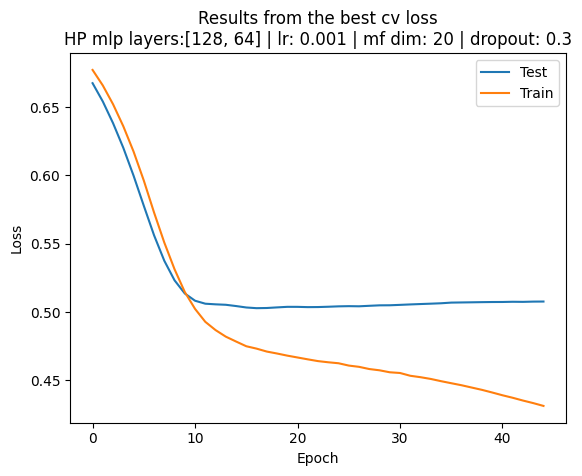

In [19]:
plt.plot(results["loss_ep"].loc[2]["test"], label = "Test")
plt.plot(results["loss_ep"].loc[2]["train"], label = "Train")
best = results.loc[2]
hp_string = f'mlp layers:{best["mlp_layer_sizes"]} | lr: {best["learning_rate"]} | mf dim: {best["mf_dim"]} | dropout: {best["dropout"]}'
plt.title("Results from the best cv loss\nHP " + hp_string)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Conclusions: 
1. Usually the 2 layers perceptron gave better results than the 3 layers perceptron while rest parameters where the same
2. Model seems to overfit
3. Lower dropout was better